# Simulate force profiles for a blue-detuned MOT for CaOH

In [1]:
using Revise

In [2]:
using
    QuantumStates, 
    OpticalBlochEquations, 
    DifferentialEquations

In [3]:
using Distributions
function average_forces(iterator_info, forces, param_to_average, f_value, f_average)
    params, iterator = iterator_info
    typeof_param = typeof(f_value(first(iterator)))
    forces_dict = Dict{typeof_param, Tuple{Int64, Float64}}()
    for (i, param) ∈ enumerate(iterator)
        force = forces[i]
        param_value = f_value(param)
        if haskey(forces_dict, param_value)
            occurrences, current_force = forces_dict[param_value]
            forces_dict[param_value] = (occurrences + 1, current_force + f_average(force, param))
        else
            forces_dict[param_value] = (1, f_average(force, param))
        end
    end
    forces_dict = sort(forces_dict)
    unique_values = collect(keys(forces_dict))
    forces_with_occurrences = collect(values(forces_dict))
    averaged_forces = [x[2] / x[1] for x in forces_with_occurrences]
    
    sorted_idxs = sortperm(unique_values)
    return unique_values[sorted_idxs], averaged_forces[sorted_idxs]
end
idx_finder = x->findall.(.==(unique(x)), Ref(x) )
function average_forces(params, forces)
    unique_params = unique(params)
    params_idxs = idx_finder(params)
    average_forces = zeros(length(unique_params))
    for (i, (param, idxs)) ∈ enumerate(zip(unique_params, params_idxs))
        param_forces = forces[idxs]
        average_forces[i] = mean(param_forces)
    end
    return unique_params, average_forces
end
# OLD
# uniform_dist = Uniform(0, 2π)
# vs = vcat([0,0.5,1,1.5,2,3,4], collect(5:5:50)) ./ (Γ / k)
# reps = 100; n = length(vs) * reps
# scan_params = Dict(
#     :v => [v .* sample_direction() for v ∈ repeat(vs, reps)],
#     :r0 => [rand(uniform_dist, 3) for _ ∈ 1:n] # .* 2π for rx ∈ 0:0.25:1.0, ry ∈ 0:0.25:1.0, rz ∈ 0:0.25:1.0),
# )
# ;
# iterator_info, forces = force_scan(p, scan_params, Iterators.zip, nthreads=20);
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end;

### Reproduce Fig. 1 from "Blue-Detuned Magneto-Optical Trap" (PRL 120, 083201 (2018))

* Values are from Steck notes of the 87Rb D2 line
* Energies are in MHz

In [4]:
λ = 780.241209686e-9
Γ = 2π * 6.065e6 # in units of MHz
m = @with_unit 87 "u"
k = 2π / λ
;

$5^2S_{1/2}$ state

In [5]:
# F = 1
QN_bounds = (E = 0.0, F = 1)
F1_lower = enumerate_states(AngularMomentumState, QN_bounds)

# F = 2
QN_bounds = (E = 6.83468261090429e9, F = 2) # GHz (in units of MHz)
F2_lower = enumerate_states(AngularMomentumState, QN_bounds)
;

$5^2P_{3/2}$

In [6]:
E_upper = 384.2304844685e12 # THz (in units of MHz)

# F = 1
QN_bounds = (E = E_upper - 72.9113e6 - 156.947e6, F = 1)
F1_upper = enumerate_states(AngularMomentumState, QN_bounds)

# F = 2
QN_bounds = (E = E_upper - 72.9113e6, F = 2)
F2_upper = enumerate_states(AngularMomentumState, QN_bounds)
;

In [7]:
ground_states = [F1_lower; F2_lower]
excited_states = [F1_upper; F2_upper]
states = [ground_states; excited_states]
;

In [8]:
d = zeros(length(states), length(states), 3)
for (i, state) in enumerate(ground_states)
    for (j, state′) in enumerate(excited_states)
        j += length(ground_states)
        for p in -1:1
            tdm = TDM(state, state′, p)
            d[i,j,p+2] = tdm
            # d[j,i,p+2] = conj(tdm)
        end
    end
end

# Magnetic moments in units of MHz/G
# For now, only assuming a field along the z axis
d_m = zeros(length(states), length(states), 3)
for (i, state) in enumerate(states)
    for (j, state′) in enumerate(states)
        for p ∈ -1:1
            if j > i
                d_m[i,j,p+2] += TDM_magnetic(state, state′, p) * (state.E == state′.E)
                d_m[i,j,p+2] += TDM_magnetic(state′, state, p) * (state.E == state′.E)
            elseif i == j
                d_m[i,j,p+2] += TDM_magnetic(state, state′, p) * (state.E == state′.E)
            end
        end
    end
end
d_m[1:3,1:3,:]     .*= (-1/2)
d_m[4:8,4:8,:]     .*= ( 1/2)
d_m[9:11,9:11,:]   .*= (2/3)
d_m[12:16,12:16,:] .*= (2/3)
# d_m ./= (Γ / (μB * 1e6))
;

In [198]:
# Laser parameters
δf11 = +11.5e6
δf22 = +26.0e6
θ₁ = 0.0
θ₂ = 0.0

Isat = 2.503
s = (113 / Isat) / 12

# pol = σ⁻
pol = σ⁺

# Create MOT beams for F=1 -> F'=1 transition
ω_F1_to_F1 = 2π * (F1_upper[1].E - F1_lower[1].E + δf11)

k̂ = +x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser1 = Laser(k̂, ϵ, ω_F1_to_F1, s)

k̂ = -x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser2 = Laser(k̂, ϵ, ω_F1_to_F1, s)

k̂ = +ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser3 = Laser(k̂, ϵ, ω_F1_to_F1, s)

k̂ = -ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser4 = Laser(k̂, ϵ, ω_F1_to_F1, s)

k̂ = +ẑ
ϵ = rotate_pol(pol, k̂)
laser5 = Laser(k̂, ϵ, ω_F1_to_F1, s)

k̂ = -ẑ
ϵ = rotate_pol(pol, k̂)
laser6 = Laser(k̂, ϵ, ω_F1_to_F1, s)

# Create MOT beams for F=2 -> F'=2 transition
ω_F2_to_F2 = 2π * (F2_upper[1].E - F2_lower[1].E + δf22)

k̂ = +x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser7 = Laser(k̂, ϵ, ω_F2_to_F2, s)

k̂ = -x̂
ϵ = exp(im * θ₁) * rotate_pol(pol, k̂)
laser8 = Laser(k̂, ϵ, ω_F2_to_F2, s)

k̂ = +ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser9 = Laser(k̂, ϵ, ω_F2_to_F2, s)

k̂ = -ŷ
ϵ = exp(im * θ₂) * rotate_pol(pol, k̂)
laser10 = Laser(k̂, ϵ, ω_F2_to_F2, s)

k̂ = +ẑ
ϵ = rotate_pol(pol, k̂)
laser11 = Laser(k̂, ϵ, ω_F2_to_F2, s)

k̂ = -ẑ
ϵ = rotate_pol(pol, k̂)
laser12 = Laser(k̂, ϵ, ω_F2_to_F2, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6, laser7, laser8, laser9, laser10, laser11, laser12]
# lasers = [laser5, laser6, laser11, laser12] # only z beams
;

In [199]:
freq_res = 1e-1
ω_min = freq_res
period = 2π / ω_min

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[3,3] = 1.0

particle = Particle()
particle.r0 = [0.0, 0.0, 0.0] 
particle.v = [0.1, 0.5, 0.1] #5 .* sample_direction() #[0.0, 0.0, 0.5] # velocity is in m/s (divided by Γ/k for the simulation)
    
# Define magnetic field
B(r) = (0., 0., 0.) #(87e2) .* (r[1], r[2], -2r[3]) # B′ = 87 G/cm
magnetic_field = B

(dρ, ρ, p) = obe(particle, states, lasers, magnetic_field, d, d_m, ρ0, true, true, λ=λ, Γ=Γ, freq_res=freq_res)
p.B = (0., 0., 0.) ./ (Γ / (μB * 1e6))
;

In [83]:
# using BenchmarkTools
# @btime ρ!(dρ, ρ0, p, 0.0)

In [218]:
t_end = 10 * p.period
tspan = (0., t_end)
step_size = 1e-3
n_periods = 2
times = range(t_end - n_periods * p.period, t_end, step=p.period * step_size)

prob = ODEProblem(ρ!, ρ0, tspan, p, reltol=1e-5) # callback=AutoAbstol(false, init_curmax=0.0)) # what does this do?
;

In [64]:
@time sol = DifferentialEquations.solve(prob, alg=DP5(), saveat=times, abstol=1e-5);

  0.312122 seconds (2.05 k allocations: 8.224 MiB)


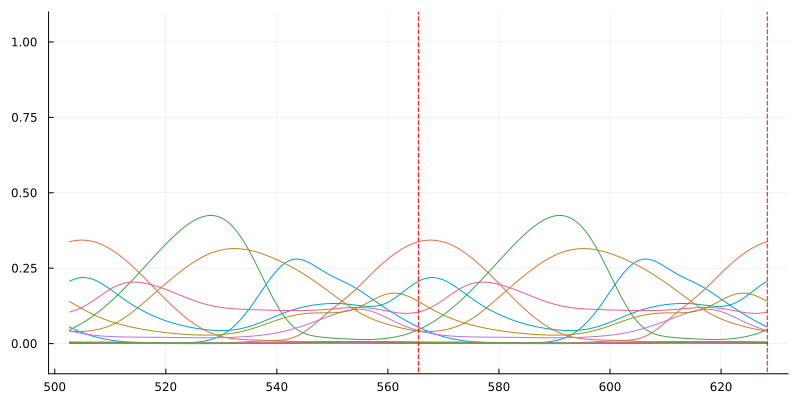

In [65]:
using Plots
plot_idxs = convert.(Int64, range(0, length(times), length(times)+1))[2:end]
plot_us = sol.u[plot_idxs]
plot_ts = sol.t[plot_idxs]

plot(plot_ts, [real(u[1,1]) for u in plot_us], size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 2:size(sol.u[1], 1)
    plot!(plot_ts, [real(u[i,i]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [66]:
using Statistics, LinearAlgebra
offset = 0
period_idx = find_idx_for_time(p.period, sol.t, true)
force_idxs = Int(length(sol.t) - 1/step_size - offset):(length(sol.t) - offset) # (period_idx - offset):(length(times) - offset)

@time F = calculate_force_from_period(p, sol; force_idxs)
println("Excited population: ", real(sum(diag(mean(sol.u[force_idxs]))[9:end])))
println("Force: ", 1e3 .* F) #sign.(force) .* abs(force ⋅ p.particle.v) / norm(p.particle.v))
println("Acceleration (10^3 m/s^2): ", 1e-3 * QuantumStates.ħ * p.k * Γ * F[3] / m)

  0.001997 seconds (3 allocations: 96 bytes)
Excited population: 0.0213638767196287
Force: [-14.014026714763864, -31.78784794596206, 2.449649485940795]
Acceleration (10^3 m/s^2): 0.5487485871682708


#### Force versus velocity

In [200]:
p.B = (0., 0., 0.) ./ (Γ / (μB * 1e6));

In [201]:
uniform_dist = Uniform(0, 2π)
vs = vcat([0,1,2,3,4], collect(5:5:40)) ./ (Γ / k)
reps = 50; n = length(vs) * reps
scan_params = Dict(
    :v => [v .* sample_direction() for v ∈ repeat(vs, reps)],
    :r0 => [rand(uniform_dist, 3) for _ ∈ 1:n] # .* 2π for rx ∈ 0:0.25:1.0, ry ∈ 0:0.25:1.0, rz ∈ 0:0.25:1.0),
)
;

In [202]:
iterator_info, forces = force_scan(p, scan_params, Iterators.zip, nthreads=10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


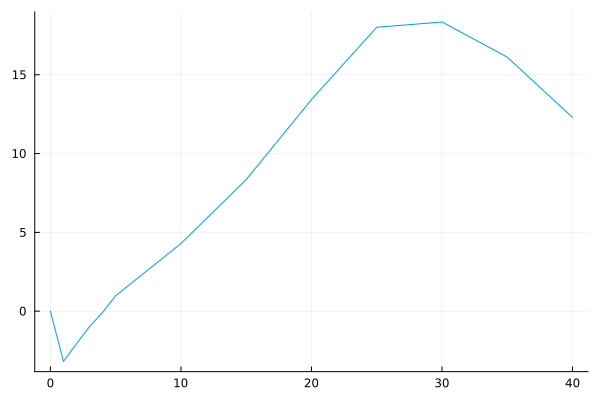

In [203]:
vs, averaged_forces = average_forces(iterator_info, forces, :v, p -> round(norm(p[1]), digits=3), (f, p) -> f ⋅ p[1] / norm(p[1]));
averaged_forces[1] = 0.0
plot(vs .* (Γ / k), (1e-3 * QuantumStates.ħ * k * Γ / m) .* averaged_forces, legend=nothing)

#### Force versus magnetic field

In [189]:
Bzs = (0:5:50) ./ (Γ / (μB * 1e6))
reps = 50; n = length(Bzs) * reps

scan_params = Dict(
    :B => repeat([(0., 0., Bz) for Bz ∈ Bzs], reps),
    :v => [0.0 .* sample_direction() ./ (Γ / k) for _ ∈ 1:n],
    :r0 => [rand(uniform_dist, 3) for _ ∈ 1:n]
    );
# scan_params = Dict(
#     :B => repeat([(0., 0., Bz) for Bz ∈ Bzs], reps),
#     :v => [(0.0, 0.0, 0.0) for _ ∈ 1:n],
#     :r0 => [(0., 0., 0.) for _ ∈ 1:n]
#     );

In [190]:
@time iterator_info, forces = force_scan(p, scan_params, Iterators.zip, nthreads=10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


 24.662444 seconds (325.16 k allocations: 1.131 GiB)


In [191]:
Bs, averaged_forces = average_forces(iterator_info, forces, :B, 
    p -> p[2][3],
    (f, p) -> f[3] #(f, p) -> f ⋅ p[1] / norm(p[1])
    );

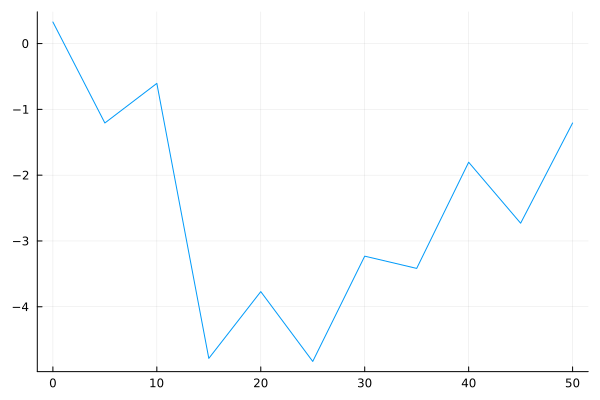

In [192]:
plot(Bs .* (Γ / (μB * 1e6)), (1e-3 * QuantumStates.ħ * k * Γ / m) .* averaged_forces, legend=nothing)

### Reproduce Fig. 6 from (New J. Phys. 18, 123017 (2016))

In [201]:
λ = 1
Γ = 2π
m = 1
k_norm = 2π / λ
;

In [202]:
# F = 1
QN_bounds = (E = 0.0, F = 1)
F1_lower = enumerate_states(AngularMomentumState, QN_bounds)
QN_bounds = (E = 1.0, F = 1)
F1_upper = enumerate_states(AngularMomentumState, QN_bounds)
;

In [203]:
ground_states = F1_lower
excited_states = F1_upper
states = [ground_states; excited_states]
;

In [204]:
d = zeros(length(states), length(states), 3)
for (i, state) in enumerate(ground_states)
    for (j, state′) in enumerate(excited_states)
        j += length(ground_states)
        for p in -1:1
            tdm = TDM(state, state′, p)
            d[i,j,p+2] = tdm
            d[j,i,p+2] = conj(tdm)
        end
    end
end

# Magnetic moments in units of MHz/G
# For now, only assuming a field along the z axis
d_m = zeros(length(states), length(states), 3)
for (i, state) in enumerate(states)
    for (j, state′) in enumerate(states)
        for p ∈ -1:1
            if j > i
                d_m[i,j,p+2] += TDM_magnetic(state, state′, p) * (state.E == state′.E)
                d_m[i,j,p+2] += TDM_magnetic(state′, state, p) * (state.E == state′.E)
            elseif i == j
                d_m[i,j,p+2] += TDM_magnetic(state, state′, p) * (state.E == state′.E)
            end
        end
    end
end
# d_m .+= permutedims(d_m, (2,1,3))
# d_m ./= (Γ / μB) # There's a 2π factor here too but it's included in the simulation code
;

In [205]:
# Laser parameters
Δ = -2.5Γ
s = 1.0
θ₁ = 0.0
θ₂ = 0.0

# Create MOT beams for F=1 -> F'=1 transition
ω_F1_to_F1 = 2π * (F1_upper[1].E - F1_lower[1].E) + Δ

k = +x̂
ϵ = exp(im * θ₁) * rotate_pol(σ⁺, k)
laser1 = Laser(k, ϵ, ω_F1_to_F1, s)

k = -x̂
ϵ = exp(im * θ₁) * rotate_pol(σ⁺, k)
laser2 = Laser(k, ϵ, ω_F1_to_F1, s)

k = +ŷ
ϵ = exp(im * θ₂) * rotate_pol(σ⁺, k)
laser3 = Laser(k, ϵ, ω_F1_to_F1, s)

k = -ŷ
ϵ = exp(im * θ₂) * rotate_pol(σ⁺, k)
laser4 = Laser(k, ϵ, ω_F1_to_F1, s)

k = +ẑ
ϵ = rotate_pol(σ⁺, k)
laser5 = Laser(k, ϵ, ω_F1_to_F1, s)

k = -ẑ
ϵ = rotate_pol(σ⁺, k)
laser6 = Laser(k, ϵ, ω_F1_to_F1, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
# lasers = [laser1, laser2]
# lasers = [laser3, laser4]
# lasers = [laser5, laser6]
;

In [207]:
freq_res = 1e-1
ω_min = freq_res
period = 2π / ω_min

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[2,2] = 1.0

particle = Particle()
particle.r0 = [0.0, 0.0, 0.0] # ./ k_norm
particle.v = [0.0, 0.0, 0.5] #.* (Γ / k_norm)

p = obe(particle, states, lasers, d, d_m, true, true, λ=λ, Γ=Γ, freq_res=freq_res)
p.B .= (0.0, 0.0, 0.0)
;

In [208]:
# using BenchmarkTools
# dρ = deepcopy(ρ0)
# @btime ρ!(dρ, ρ0, p, 0.0)

In [209]:
t_end = 5period
tspan = (0., t_end)
times = range(t_end - period, t_end, step=period/1000)
# times = range(t_end - 3p.period, t_end, step=period/1000)

prob = ODEProblem(ρ!, ρ0, tspan, p, saveat=times)#, callback=AutoAbstol(false, init_curmax=0.0)) # what does this do?
;

In [210]:
@time sol = DifferentialEquations.solve(prob, alg=DP5(), abstol=1e-4);

  0.003487 seconds (1.05 k allocations: 716.719 KiB)


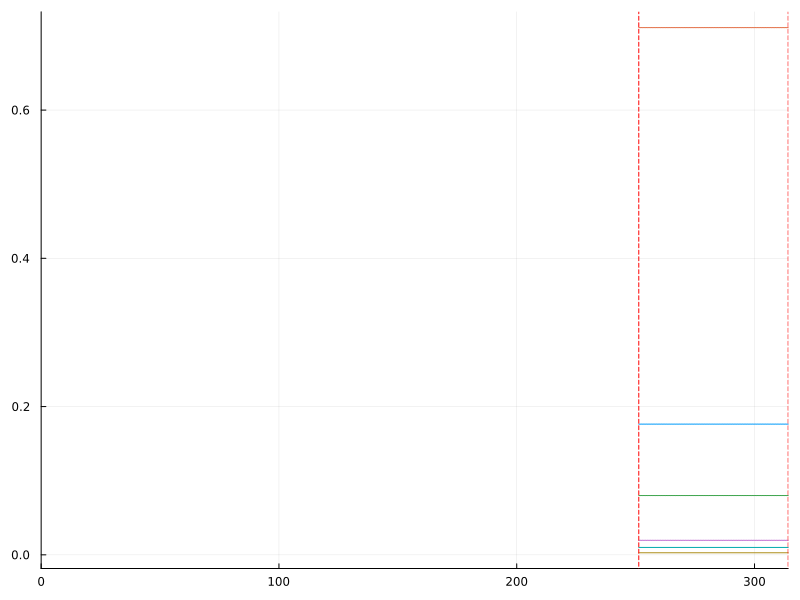

In [211]:
using Plots
plot_idxs = convert.(Int64, range(0, length(times), length(times)+1))[2:end]
plot_us = sol.u[plot_idxs]
plot_ts = sol.t[plot_idxs]

plot(plot_ts, [norm(u[1,1]) for u ∈ plot_us], size=(800, 600), xlim=(0.0,t_end), legend=nothing)
for i ∈ 2:size(sol.u[1], 1)
    plot!(plot_ts, [norm(u[i,i]) for u ∈ plot_us])
end
offset = 0
vline!([sol.t[end] - period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [212]:
using Statistics, LinearAlgebra
offset = 0
period_idx = find_idx_for_time(p.period, sol.t, true)
force_idxs = (period_idx - offset + 1):(length(times) - offset)

@time F = calculate_force_from_period(p, sol; force_idxs)
println("Excited population: ", real(sum(diag(mean(sol.u[period_idx:end]))[4:end])))
println("Force: ", 1e3 .* F) #sign.(force) .* abs(force ⋅ p.particle.v) / norm(p.particle.v))
println("Acceleration (10³ m/s^2): ", 1e-3 * QuantumStates.ħ * k_norm * Γ * F / m)

  0.000338 seconds (1.00 k allocations: 31.344 KiB)
Excited population: 0.03240168099324065
Force: [0.0001255802041066345, 0.00014299388792752415, 2.0925692369244553]
Acceleration (10³ m/s^2): [5.228258863323056e-43, 5.953239742493818e-43, 8.711957221201435e-39]


#### Force versus velocity

In [125]:
function prob_func!(p, scan_values, i)
    # Update velocity and position
    p.v .= (scan_values.v[i], 0.0, 0.1) #sample_direction(inner_config.v[i])
    p.r0 .= rand(uniform_dist, 3) .* 2π
    return nothing
end
function param_func(p, scan_values, i)
    return round(norm(p.v), digits=2)
end
function output_func(p, sol)
    f = calculate_force_from_period(p, sol)
    return f[1]
end
;

In [127]:
vs = repeat(0:0.2:7, 100)
scan_values = (v = vs,)
@time scan_params, forces = force_scan(prob, scan_values, prob_func!, param_func, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.518138 seconds (7.41 M allocations: 2.570 GiB)


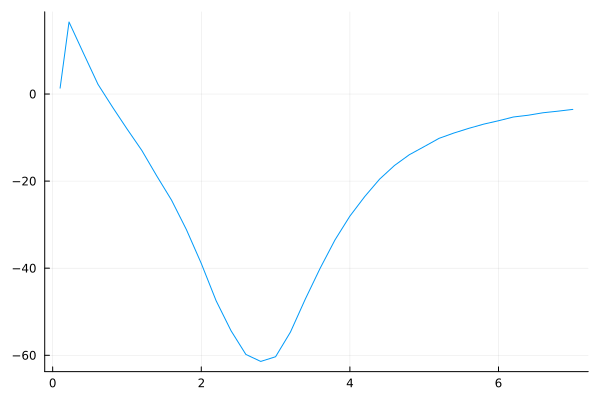

In [128]:
vs, averaged_forces = average_forces(scan_params, forces)
plot(vs, 1e3 .* averaged_forces, legend=nothing)

#### Force versus magnetic field

In [221]:
function prob_func!(p, scan_values, i)
    # Update velocity and position
    p.v .= sample_direction(scan_values.vs[i])
    p.r0 .= rand(uniform_dist, 3) .* 2π
    # Round `v` to ensure that the OBEs are periodic
    p.v .= round_vel(p.v, p.freq_res)
    p.B .= (0.0, 0.0, scan_values.Bz[i])
    return nothing
end
function param_func(p, scan_values, i)
    return p.B[3]
end
function output_func(p, sol)
    f = calculate_force_from_period(p, sol)
    return f[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [224]:
n_samples = 1000

Bzs = (0:0.1:2.0) ./ 2π
vs  = 0.1 .* ones(length(Bzs))

scan_values = (Bz = repeat(Bzs, n_samples), vs = repeat(vs, n_samples))
@time scan_params, forces = force_scan(prob, scan_values, prob_func!, param_func, output_func);

 11.310173 seconds (43.25 M allocations: 14.992 GiB, 19.23% gc time)


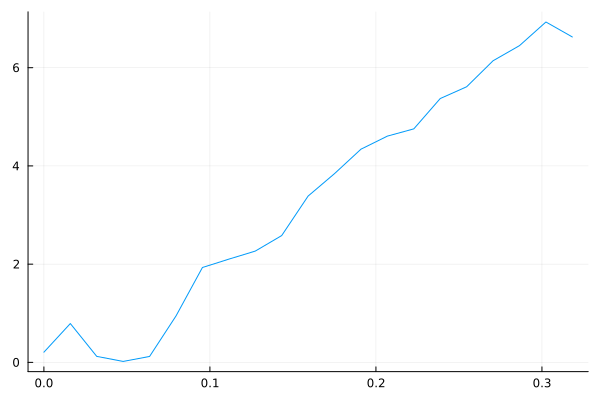

In [225]:
Bzs, averaged_forces = average_forces(scan_params, forces)
plot(Bzs, 1e3 * averaged_forces, legend=nothing)

##### Attempt dense output for the force

In [3110]:
# Dense output, how does it compare?
@time sol = DifferentialEquations.solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-7, dense=true);

  0.205279 seconds (338.70 k allocations: 1.073 GiB, 41.16% gc time)


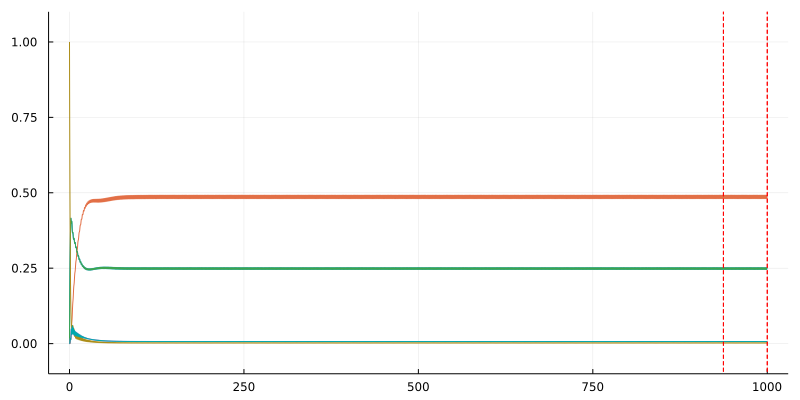

In [3111]:
for i in 1:6
    plot!(i, [real(sol(j)[i,i]) for j in 1:p.period])
end
plot!()
offset = 0
vline!([sol.t[end] - period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [3112]:
ts = 500:0.001:1000
sum(sol(t) for t ∈ ts) ./ length(ts) |> diag

6-element Vector{ComplexF64}:
   0.24883767685787198 + 0.0im
    0.4863119840409715 + 0.0im
     0.248837676857872 + 0.0im
  0.006863770406026248 + 0.0im
 0.0022851214312301607 + 0.0im
  0.006863770406026251 + 0.0im

### CaOH

In [4]:
λ = 626e-9
Γ = 2π * 6.4e6 # in units of MHz
m = @with_unit 57 "u"
k = 2π / λ
;

##### Load $\tilde{X}(000)$ and $\tilde{A}(000)$ Hamiltonians

In [5]:
HX = load_from_file("CaOH_000_N0to3_Hamiltonian", "X://My Drive//github//QuantumStates//Hamiltonians//")
HA = load_from_file("CaOH_A000_J12to52_Hamiltonian", "X://My Drive//github//QuantumStates//Hamiltonians//")

HX_N1 = subspace(HX, (N=1,))
HA_J12 = subspace(HA, (Ω=1/2, J=1/2,))
evaluate!(HX_N1); QuantumStates.solve!(HX_N1)
evaluate!(HA_J12); QuantumStates.solve!(HA_J12)

# Add Zeeman term to the X state Hamiltonian
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
HX_N1 = add_to_H(HX_N1, :B_z, gS * μB * Zeeman_z)
HX_N1.parameters.B_z = 0.0#1e-3
# evaluate!(HX_N1); QuantumStates.solve!(HX_N1)

# Convert A states from Hund's case (a) to case (b)
HX_0110 = load_from_file("CaOH_BendingMode_Hamiltonian", "X://My Drive//github//QuantumStates//Hamiltonians//")
states_A_J12_caseB = convert_basis(HA_J12.states, HX_0110.basis)
basis_idxs, reduced_A_J12_caseB_basis = states_to_basis(states_A_J12_caseB)
full_basis = [HX_N1.basis; reduced_A_J12_caseB_basis]

for i ∈ eachindex(states_A_J12_caseB)
    states_A_J12_caseB[i].coeffs = states_A_J12_caseB[i].coeffs[basis_idxs]
    states_A_J12_caseB[i].basis = reduced_A_J12_caseB_basis
end

states = [HX_N1.states; states_A_J12_caseB]
for state ∈ states
    state.E *= 1e6
end
;

In [6]:
d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)
basis_tdms = get_tdms_two_bases(HX_N1.basis, reduced_A_J12_caseB_basis, TDM)
tdms_between_states!(d_ge, basis_tdms, HX_N1.states, states_A_J12_caseB)
d[1:12, 13:16, :] .= d_ge

d_m = zeros(ComplexF64, 16, 16, 3)
d_m_gg = zeros(ComplexF64, 12, 12, 3)
basis_tdms_m = get_basis_tdms(HX_N1.basis, TDM_magnetic)
tdms_between_states!(d_m_gg, basis_tdms_m, HX_N1.states, HX_N1.states)
d_m[1:12, 1:12, :] .= d_m_gg
;

In [7]:
# Laser parameters
J12_energy = energy(states[1])
J32_energy = energy(states[5])
A_energy = energy(states[13])

δJ12 = +13.0e6
δJ32 = +13.0e6
θ₁ = 0.0
θ₂ = 0.0
s_J12 = 20.0
s_J32 = 20.0
pol = σ⁻

ω_J12 = 2π * (A_energy - J12_energy + δJ12)
ω_J32 = 2π * (A_energy - J32_energy + δJ32)

ϵ = exp(im * θ₁) * rotate_pol(pol, +x̂); laser1 = Laser(+x̂, ϵ, ω_J12, s_J12)
ϵ = exp(im * θ₁) * rotate_pol(pol, -x̂); laser2 = Laser(-x̂, ϵ, ω_J12, s_J12)
ϵ = exp(im * θ₂) * rotate_pol(pol, +ŷ); laser3 = Laser(+ŷ, ϵ, ω_J12, s_J12)
ϵ = exp(im * θ₂) * rotate_pol(pol, -ŷ); laser4 = Laser(-ŷ, ϵ, ω_J12, s_J12)
ϵ = rotate_pol(pol, +ẑ); laser5 = Laser(+ẑ, ϵ, ω_J12, s_J12)
ϵ = rotate_pol(pol, -ẑ); laser6 = Laser(-ẑ, ϵ, ω_J12, s_J12)

ϵ = exp(im * θ₁) * rotate_pol(pol, +x̂); laser7 = Laser(+x̂, ϵ, ω_J32, s_J32)
ϵ = exp(im * θ₁) * rotate_pol(pol, -x̂); laser8 = Laser(-x̂, ϵ, ω_J32, s_J32)
ϵ = exp(im * θ₂) * rotate_pol(pol, +ŷ); laser9 = Laser(+ŷ, ϵ, ω_J32, s_J32)
ϵ = exp(im * θ₂) * rotate_pol(pol, -ŷ); laser10 = Laser(-ŷ, ϵ, ω_J32, s_J32)
ϵ = rotate_pol(pol, +ẑ); laser11 = Laser(+ẑ, ϵ, ω_J32, s_J32)
ϵ = rotate_pol(pol, -ẑ); laser12 = Laser(-ẑ, ϵ, ω_J32, s_J32)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6, laser7, laser8, laser9, laser10, laser11, laser12]
;

In [9]:
# Set initial conditions
particle = Particle()
particle.r0 = [0.1, 0.0, 0.0]
particle.v = [0.0, 0.0, 0.0]

freq_res = 1e-2
ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[1,1] = 1.0
;

In [10]:
p = obe(particle, states, lasers, d, d_m, true, true; λ=λ, Γ=Γ, freq_res=freq_res)
p = (; p..., basis_tdms, basis_tdms_m, HX_N1, d_ge, d_m_gg)
;

In [11]:
# using BenchmarkTools
# dρ = deepcopy(ρ0)
# @btime ρ!($dρ, $ρ0, $p, 0.0)

In [12]:
p.B .= (0.0, 0.0, 50.0) ./ (Γ / (μB * 1e6))
p.v .= (0.0, 0.05, 0.05)

t_end = 2.91p.period
tspan = (0., t_end)
step_size = 1e-2
times = range(0, t_end, step=p.period * step_size)
# times = range(t_end - p.period, t_end, step=p.period * step_size)
prob = ODEProblem(ρ!, ρ0, tspan, p, saveat=times) #, callback=AutoAbstol(false, init_curmax=0.0)) # what does this do?
;

In [14]:
@time sol = DifferentialEquations.solve(prob, alg=DP5(), saveat=times, abstol=1e-5); #abstol=1e-5);

 26.184295 seconds (45.50 M allocations: 2.707 GiB, 2.49% gc time, 96.97% compilation time)


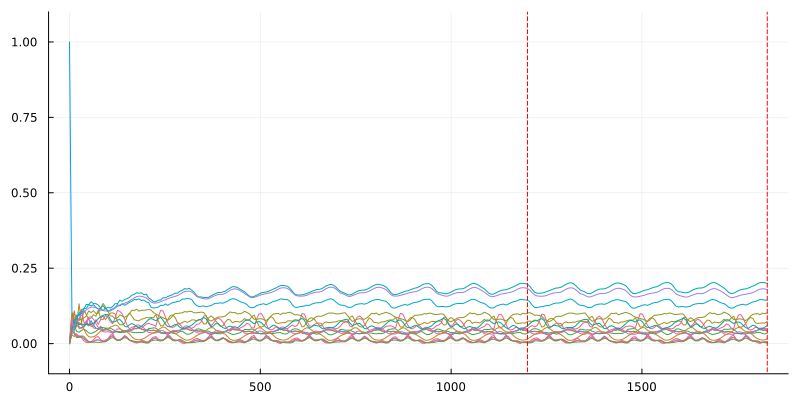

In [15]:
using Plots
plot_idxs = convert.(Int64, range(0, length(times), length(times)+1))[2:end]
plot_us = sol.u[plot_idxs]
plot_ts = sol.t[plot_idxs]

plot(plot_ts, [real(u[1,1]) for u in plot_us], size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 2:size(sol.u[1], 1)
    plot!(plot_ts, [real(u[i,i]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [16]:
using Statistics, LinearAlgebra
offset = 0
period_idx = find_idx_for_time(p.period, sol.t, true)
force_idxs = (period_idx - offset):(length(times) - offset)
@time force = calculate_force_from_period(p, sol)

# @time force = calculate_force_from_period(p, sol)
# println("Excited population: ", real(sum(diag(mean(sol.u[force_idxs]))[9:end])))
println("Force: ", force)
println("Acceleration (10^3 m/s^2): ", 1e-3 * QuantumStates.ħ * k * Γ * force[3] / m)

  0.220876 seconds (800.39 k allocations: 41.347 MiB, 99.63% compilation time)
Force: [0.003090926023406696, -0.034468535531864, 0.026545172373694446]
Acceleration (10^3 m/s^2): 11.937218278466453


#### Force versus velocity

In [17]:
# Why not use `EnsembleProblem`? This makes a new copy for every single problem, which we won't need
# Instead, we make `nthreads` problems
# prob = ODEProblem(ρ!, ρ0, tspan, p)
# ensemble_prob = EnsembleProblem(prob, prob_func=prob_func_inner)
# @time sim = solve(ensemble_prob, DP5(), EnsembleThreads(), trajectories=100, batch_size=10, abstol=1e-5, save_everystep=false)
# ;

In [18]:
function prob_func!(p, scan_values, i)
    # Update velocity and position
    p.v .= sample_direction(scan_values.v[i])
    p.v .= round_vel(p.v, p.freq_res)    
    p.r0 .= rand(uniform_dist, 3) .* 2π
    return nothing
end
function param_func(p, scan_values, i)
    return scan_values.v[i]
end
function output_func(p, sol)
    f = calculate_force_from_period(p, sol)
    return (f ⋅ p.v) / norm(p.v)
end
;

In [19]:
prob.p.B .= (0.0, 0.0, 20.0) ./ (Γ / (μB * 1e6));

In [20]:
# vs = repeat([0:0.5:5; 5:5:40], 50) ./ (Γ / k)
vs = repeat(0:0.5:5, 50) ./ (Γ / k)
scan_values = (v = vs,)
@time scan_params, forces = force_scan(prob, scan_values, prob_func!, param_func, output_func; n_threads=20);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


 50.182210 seconds (6.27 M allocations: 1012.778 MiB, 0.35% gc time, 5.14% compilation time)


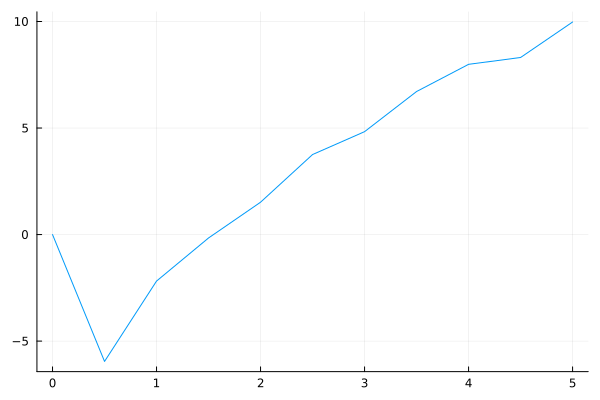

In [21]:
vs, averaged_forces = average_forces(scan_params, forces)
averaged_forces[1] = 0.0
plot(vs .* (Γ / k), (1e-3 * QuantumStates.ħ * k * Γ / m) .* averaged_forces, legend=nothing)

#### Force versus magnetic field

In [96]:
function prob_func!(p, scan_values, i)
    # Update velocity and position
    p.v .= sample_direction(scan_values.v[i])
    p.r0 .= rand(uniform_dist, 3) .* 2π
    # Round `v` to ensure that the OBEs are periodic
    p.v .= round_vel(p.v, p.freq_res)
    
    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_values.Bz[i]
    if p.HX_N1.parameters.B_z != Bz
        p.B .= (0.0, 0.0, Bz)
        p.HX_N1.parameters.B_z = scan_values.Bz[i]
        evaluate!(HX_N1)
        QuantumStates.solve!(HX_N1)
        for i ∈ eachindex(HX_N1.states)
            HX_N1.states[i].E *= 1e6
        end
        p.states[1:12] .= HX_N1.states

        # Update TDMs
        tdms_between_states!(p.d_ge, p.basis_tdms, HX_N1.states, states_A_J12_caseB)
        p.d[1:12, 13:16, :] .= d_ge
        tdms_between_states!(d_m_gg, p.basis_tdms_m, HX_N1.states, HX_N1.states)
        p.d_m[1:12, 1:12, :] .= d_m_gg
    end
    
    return nothing
end
function param_func(p, scan_values, i)
    return scan_values.Bz[i]
end
function output_func(p, sol)
    f = calculate_force_from_period(p, sol)
    return f[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [ ]:
n_samples = 100

Bzs = (0:2:50) ./ (Γ / (μB * 1e6))
vs  = (1.0 / (Γ / k)) .* ones(length(Bzs))

scan_values = (Bz = repeat(Bzs, n_samples), v = repeat(vs, n_samples))
@time scan_params, forces = force_scan(prob, scan_values, prob_func!, param_func, output_func);

Progress:  22%|██████████                               |  ETA: 0:34:17Progress: 100%|█████████████████████████████████████████| Time: 0:09:26Progress:   3%|██                                       |  ETA: 0:10:06Progress:   2%|█                                        |  ETA: 0:26:57Progress:   2%|█                                        |  ETA: 0:29:24Progress:   3%|██                                       |  ETA: 0:35:13Progress:   5%|███                                      |  ETA: 0:37:30Progress:  30%|█████████████                            |  ETA: 0:06:39Progress:   7%|████                                     |  ETA: 0:38:53Progress:  31%|█████████████                            |  ETA: 0:06:35Progress:   8%|████                                     |  ETA: 0:38:54Progress:  36%|███████████████                          |  ETA: 0:05:52Progress:   9%|████                                     |  ETA: 0:38:55Progress:  10%|████                                     |  ETA: 0:38:52Progre

567.196082 seconds (4.55 M allocations: 6.863 GiB, 0.53% gc time)


Progress:  22%|██████████                               |  ETA: 0:34:10

In [ ]:
Bzs, averaged_forces = average_forces(scan_params, forces)
plot(Bzs .* (Γ / (μB * 1e6)), (1e-3 * QuantumStates.ħ * k * Γ / m) .* averaged_forces, legend=nothing)